# Implementation of the paper Deep Bayesian Active Learning with Image Data using PyTorch and modAL.

modAL is an active learning framework for Python3, designed with modularity, flexibility and extensibility in mind. Built on top of scikit-learn, it allows you to rapidly create active learning workflows with nearly complete freedom. What is more, you can easily replace parts with your custom built solutions, allowing you to design novel algorithms with ease.

Since modAL only supports sklearn models, we will also use skorch, a scikit-learn compatible neural network library that wraps PyTorch.


# 1: Connect the notebook to your Google Drive


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
root_dir = "/content/gdrive/My Drive/Project/ADLR"
!ls "/content/gdrive/My Drive/Project/ADLR"
!cd "/content/gdrive/My Drive/Project/ADLR"
%cd "/content/gdrive/My Drive/Project/ADLR"

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
!pip install toma
!pip install modAL
!pip install scikit-optimize
%cd "/content/gdrive/My Drive/Project/ADLR/cnn-gp-master/"
%cd "/content/gdrive/My Drive/Project/ADLR"


In [1]:
import torch
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.modules.loss import _Loss
from torch import Tensor

from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST

import skorch
# from skorch.classifier_for_BNN import NeuralNetClassifier
from skorch.classifier_for_BNN import NeuralNetClassifier as NeuralNetClassifier_BNN
from skorch import NeuralNetClassifier
from modAL.models import ActiveLearner, Committee
from tqdm.notebook import tqdm

import pandas as pd
import os
import sys

from sklearn import preprocessing, model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import _scorer

from scipy.stats import uniform, loguniform, randint
import uncertainty_toolbox as uct
import matplotlib.pyplot as plt

from blitz.modules import BayesianLinear
from blitz.modules import BayesianConv2d
from blitz.utils import variational_estimator
from blitz.modules.base_bayesian_module import BayesianModule
from tensorflow import keras

from batchbald_redux import joint_entropy
from batchbald_redux.batchbald import *
from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
)

D:\Program\Anaconda\envs\torch_test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2: Classifier we will be using

We will use the architecture described in the paper.

## CNN

In [50]:
class CNN(nn.Module):
    def __init__(self,):
        super(CNN, self).__init__()
        self.convs = nn.Sequential(
                                nn.Conv2d(1,32,4),
                                nn.ReLU(),
                                nn.Conv2d(32,32,4),
                                nn.ReLU(),
                                nn.MaxPool2d(2),
                                nn.Dropout(0.25)
        )
        self.fcs = nn.Sequential(
                                nn.Linear(11*11*32,128),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(128,10),
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,11*11*32)
        out = self.fcs(out)
        return out

## Bayesian CNN

In [2]:
@variational_estimator
class BayesianCNN(nn.Module):
    def __init__(self, conv_rho=-8, conv_sigma_1=1.2, conv_sigma_2=0.009, conv_pi=0.5, linear_rho=-8, linear_sigma_1=0.4, linear_sigma_2=0.003, linear_pi=0.5):
        super().__init__()

        self.conv_rho = conv_rho
        self.conv_sigma_1 = conv_sigma_1
        self.conv_sigma_2 = conv_sigma_2
        self.conv_pi = conv_pi
        self.linear_rho = linear_rho
        self.linear_sigma_1 = linear_sigma_1
        self.linear_sigma_2 = linear_sigma_2
        self.linear_pi = linear_pi

        self.convs = nn.Sequential(
            BayesianConv2d(
                1, 32, (4, 4),
                prior_sigma_1 = self.conv_sigma_1,
                prior_sigma_2 = self.conv_sigma_2,
                prior_pi = self.conv_pi,
                posterior_rho_init = self.conv_rho
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            BayesianConv2d(
                32, 32, (4, 4),
                prior_sigma_1 = self.conv_sigma_1,
                prior_sigma_2 = self.conv_sigma_2,
                prior_pi = self.conv_pi,
                posterior_rho_init = self.conv_rho
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # self.convs = nn.Sequential(
        #                         nn.Conv2d(1, 32, (4, 4)),
        #                         nn.ReLU(),
        #                         nn.Conv2d(32, 32, (4, 4)),
        #                         nn.ReLU(),
        #                         nn.MaxPool2d(2),
        # )
        self.fcs = nn.Sequential(
            BayesianLinear(
                11*11*32, 128,
                prior_sigma_1 = self.linear_sigma_1,
                prior_sigma_2 = self.linear_sigma_2,
                prior_pi = self.linear_pi,
                posterior_rho_init = self.linear_rho
            ),
            nn.ReLU(),
            BayesianLinear(
                128, 10,
                prior_sigma_1 = self.linear_sigma_1,
                prior_sigma_2 = self.linear_sigma_2,
                prior_pi = self.linear_pi,
                posterior_rho_init = self.linear_rho
            ),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,11*11*32)
        out = self.fcs(out)
        return out


def kl_divergence_from_nn(model):

    """
    Gathers the KL Divergence from a nn.Module object
    Works by gathering each Bayesian layer kl divergence and summing it, doing nothing with the non Bayesian ones
    """
    kl_divergence = 0
    for module in model.modules():
        if isinstance(module, (BayesianModule)):
            kl_divergence += module.log_variational_posterior - module.log_prior
    return kl_divergence


class sample_elbo_class(_Loss):
    __constants__ = ['reduction']

    def __init__(self, size_average=None, reduce=None, reduction: str = 'mean', complexity_cost_weight=None) -> None:
        super(sample_elbo_class, self).__init__(size_average, reduce, reduction)

        self.complexity_cost_weight = complexity_cost_weight
        self.model = None

    def forward(self, input: Tensor, target: Tensor, model) -> Tensor:
        self.model = model
        return self.sample_elbo(input, target, model=model, complexity_cost_weight=self.complexity_cost_weight)

    def nn_kl_divergence(self, model):
        return kl_divergence_from_nn(model)

    def sample_elbo(self,
                    inputs,
                    labels,
                    model=None,
                    sample_nbr=20,
                    criterion=nn.CrossEntropyLoss(),
                    complexity_cost_weight=1):

        loss = 0
        for _ in range(sample_nbr):
            loss += F.cross_entropy(inputs, labels)
            loss += self.nn_kl_divergence(model) * complexity_cost_weight
        return loss / sample_nbr

## Ensemble based method

## RandomForest


In [41]:
from sklearn.ensemble import RandomForestClassifier

## Gaussian Process

In [54]:
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kernels
kernel = kernels.DotProduct(1.0, sigma_0_bounds=(1.0e-03, 1.0e0)) + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
#kernel = kernels.DotProduct(1, sigma_0_bounds='fixed') + kernels.WhiteKernel(8.1, noise_level_bounds='fixed')
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)

## GP-CNN

In [23]:
from cnn_gp import Sequential, Conv2d, ReLU

model = Sequential(
    Conv2d(kernel_size=4,padding=0),
)
#model = model.cuda()
nn_Conv2d_1 = model.nn(channels=50, in_channels=1, out_channels=32)
nn_Conv2d_2 = model.nn(channels=50, in_channels=32, out_channels=32)

class GP_CNN(nn.Module):
    def __init__(self,):
        super(GP_CNN, self).__init__()
        self.convs = nn.Sequential(
                                #nn.Conv2d(1,32,4),
                                nn_Conv2d_1,
                                nn.ReLU(),
                                nn.Conv2d(32,32,4),
                                #nn_Conv2d_2,
                                nn.ReLU(),
                                nn.MaxPool2d(2,2),
                                #nn.Dropout(0.25)
        )
        self.fcs = nn.Sequential(
                                nn.Linear(11*11*32,128),
                                nn.ReLU(),
                                #nn.Dropout(0.5),
                                nn.Linear(128,10),
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,11*11*32)
        out = self.fcs(out)
        return out

# 3: Dataset

## Read training data

In [3]:
mnist_train = MNIST('.', train=True, download=True, transform=ToTensor())
mnist_test  = MNIST('.', train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=False, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=False, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_train = X_train.detach().cpu().numpy()
y_train = y_train.detach().cpu().numpy()
X_test , y_test  = next(iter(testdataloader))
X_test = X_test.detach().cpu().numpy()
y_test = y_test.detach().cpu().numpy()

C:\Users\mengdexuan\AppData\Roaming\Python\Python37\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Preprocessing

In [4]:
X_train = X_train.reshape(60000, 1, 28, 28)
X_test = X_test.reshape(10000, 1, 28, 28)

### image reshape

In [5]:
def img_reshape(list):
    re_list = []
    for X in list:
        re_list.append(X.reshape(X.shape[0], -1))
    return re_list

## Initial labelled data

We initialize the labelled set with 20 balanced randomly sampled examples

In [43]:
initial_idx = np.array([],dtype=int)

for i in range(10):
    idx = np.where(y_train==i)[0][0:50]
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

In [8]:
X_initial = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/X_initial_50.npy')
y_initial = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/y_initial_50.npy')
initial_idx = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/initial_idx_50.npy')
X_initial_1000 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/X_initial_1000.npy')
y_initial_1000 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/y_initial_1000.npy')
initial_idx_1000 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/initial_idx_1000.npy')

## Initial unlabelled pool

In [44]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [45]:
X_list = [X_test, X_pool, X_initial]

X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

## labelled data for tuning
150 in total, 50 initial + 100 queries, same number with the active learning

In [25]:
tune_index = np.array([],dtype=int)

for i in range(10):
    idx = np.where(y_train==i)[0][0:15]
    tune_index = np.concatenate((tune_index, idx))

X_tune = X_train[tune_index]
y_tune = y_train[tune_index]

# Plus: Hparams Tuning

## Plus.1 Gaussian Process Tuning

In [ ]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kernels
kernel_1 = 1.0 * kernels.RBF(1.0, length_scale_bounds=(1.0e0, 1.0e03)) + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
kernel_2 = kernels.ConstantKernel(1.0, constant_value_bounds=(1.0e-03, 1.0e03)) + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
kernel_3 = kernels.DotProduct(1.0, sigma_0_bounds=(1.0e-03, 1.0e0)) + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
kernel_4 = kernels.Matern(length_scale=1.0, length_scale_bounds=(1.0e0, 1.0e03), nu=2) + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
kernel_5 = kernels.PairwiseKernel(1.0, gamma_bounds=(1.0e-03, 1.0e03), metric='linear') + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
kernel_6 = kernels.RationalQuadratic(length_scale=1.0, length_scale_bounds=(1.0e0, 1.0e03), alpha=1.0, alpha_bounds=(1.0e-01, 1.0e02)) + kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))
#kernel_7 = kernels.WhiteKernel(1.0, noise_level_bounds=(1.0e-03, 1.0e1))

gpc = GaussianProcessClassifier(kernel=kernel_3, n_restarts_optimizer=10)
gpc.get_params().keys()

dict_keys(['copy_X_train', 'kernel__k1', 'kernel__k2', 'kernel__k1__sigma_0', 'kernel__k1__sigma_0_bounds', 'kernel__k2__noise_level', 'kernel__k2__noise_level_bounds', 'kernel', 'max_iter_predict', 'multi_class', 'n_jobs', 'n_restarts_optimizer', 'optimizer', 'random_state', 'warm_start'])

## Plus.2: Random Search

In [ ]:
from time import time
import scipy.stats as stats
from sklearn.utils.fixes import loguniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# specify parameters and distributions to sample from
param_dist = {
    "kernel__k1__sigma_0": loguniform(1e-3, 1e3),
    'kernel__k2__noise_level': loguniform(1e-3, 1e3),
    #'kernel__gamma': loguniform(1e-3, 1e3),
    #'kernel__metric': ['linear', 'additive_chi2', 'chi2', 'poly', 'polynomial', 'rbf', 'laplacian', 'sigmoid', 'cosine']
}

# run randomized search
n_iter_search = 6
random_search = RandomizedSearchCV(
    gpc, param_distributions=param_dist, n_iter=n_iter_search,cv=3
)

start = time()
random_search.fit(X_initial_re, y_initial)
print(
    "RandomizedSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time() - start), n_iter_search)
)
report(random_search.cv_results_, n_top=6)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


KeyboardInterrupt: ignored

### Scikit-Optimization

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import time

In [ ]:
# log-uniform: understand as search over p = exp(x) by varying x
#kernel = gp.kernels.Matern(length_scale=[1,1,1], length_scale_bounds="fixed", nu=1.5) + gp.kernels.WhiteKernel(noise_level=0.2,noise_level_bounds="fixed")
#+ gp.kernels.RationalQuadratic()
kernel = kernels.DotProduct(1.0, sigma_0_bounds='fixed') + kernels.WhiteKernel(1.0, noise_level_bounds='fixed')
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)
n_iter_search = 50
opt = BayesSearchCV(
    gpc,
    {
        "kernel__k1__sigma_0": (1e-3, 1e3, 'log-uniform'),
        'kernel__k2__noise_level': (1e-3, 1e3, 'log-uniform'),
    },
    n_iter=n_iter_search,
    cv=3,
    n_jobs=15,
    n_points=5    
)

start = time.time()
opt.fit(X_pool_re[:300], y_pool[:300])
print(
    "BayesSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time.time() - start), n_iter_search)
)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test_re[:100], y_test[:100]))
print("best params: %s" % str(opt.best_params_))

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


TypeError: ignored

In [ ]:
print(
    "BayesSearchCV took %.2f seconds for %d candidates parameter settings."
    % ((time.time() - start), n_iter_search)
)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test_re[:100], y_test[:100]))
print("best params: %s" % str(opt.best_params_))

BayesSearchCV took 63.03 seconds for 50 candidates parameter settings.
val. score: 0.8333333333333334
test score: 0.8
best params: OrderedDict([('kernel__k1__sigma_0', 0.032810185608881354), ('kernel__k2__noise_level', 8.116056461175676)])


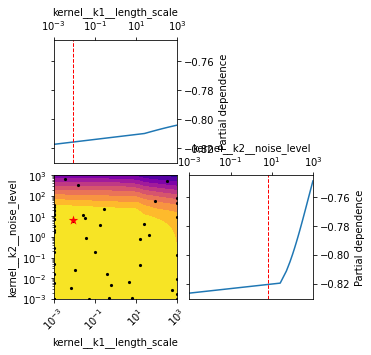

In [ ]:
import matplotlib.pyplot as plt
_ = plot_objective(opt.optimizer_results_[0],
                   dimensions=["kernel__k1__length_scale", "kernel__k2__noise_level"],
                   minimum='expected_minimum',
                   cmap='plasma_r'
                  )
plt.show()

## Plus.3 BayesianCNN Tuning

In [4]:
tune_index = np.array([],dtype=int)

for i in range(10):
    idx = np.where(y_train==i)[0][0:10]
    tune_index = np.concatenate((tune_index, idx))

X_tune = X_train[tune_index]
y_tune = y_train[tune_index]

import random
random.seed(0)
random.shuffle(X_tune)
random.seed(0)
random.shuffle(y_tune)
X_train = 0
y_train = 0

In [5]:
@variational_estimator
class BayesianCNN(nn.Module):
    def __init__(self, conv_rho=-10, conv_sigma_1=1, conv_sigma_2=0.001, conv_pi=0.5, linear_rho=-10, linear_sigma_1=1, linear_sigma_2=0.001, linear_pi=0.5):
        super().__init__()

        self.conv_rho = conv_rho
        self.conv_sigma_1 = conv_sigma_1
        self.conv_sigma_2 = conv_sigma_2
        self.conv_pi = conv_pi
        self.linear_rho = linear_rho
        self.linear_sigma_1 = linear_sigma_1
        self.linear_sigma_2 = linear_sigma_2
        self.linear_pi = linear_pi

        self.convs = nn.Sequential(
            # nn.BatchNorm2d(1),
            nn.Conv2d(
                1, 32, (4, 4),
                # prior_sigma_1 = self.conv_sigma_1,
                # prior_sigma_2 = self.conv_sigma_2,
                # prior_pi = self.conv_pi,
                # posterior_rho_init = self.conv_rho
                ),
            nn.ReLU(),
            nn.Conv2d(
                32, 32, (4, 4),
                # prior_sigma_1 = self.conv_sigma_1,
                # prior_sigma_2 = self.conv_sigma_2,
                # prior_pi = self.conv_pi,
                # posterior_rho_init = self.conv_rho
                ),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        # self.convs = nn.Sequential(
        #                         nn.Conv2d(1, 32, (4, 4)),
        #                         nn.ReLU(),
        #                         nn.Conv2d(32, 32, (4, 4)),
        #                         nn.ReLU(),
        #                         nn.MaxPool2d(2),
        # )
        self.fcs = nn.Sequential(
            nn.Linear(
                11*11*32, 128,
                # prior_sigma_1 = self.linear_sigma_1,
                # prior_sigma_2 = self.linear_sigma_2,
                # prior_pi = self.linear_pi,
                # posterior_rho_init = self.linear_rho
            ),
            nn.ReLU(),
            BayesianLinear(
                128, 10,
                prior_sigma_1 = self.linear_sigma_1,
                prior_sigma_2 = self.linear_sigma_2,
                prior_pi = self.linear_pi,
                posterior_rho_init = self.linear_rho
            )
        )

    def forward(self, x):
        out = x
        out = self.convs(out)
        out = out.view(-1,11*11*32)
        out = self.fcs(out)
        return out


class Data():
    def __init__(self):

        mnist_train = MNIST('.', train=True, download=True, transform=ToTensor())
        mnist_test = MNIST('.', train=False, download=True, transform=ToTensor())
        traindataloader = DataLoader(mnist_train, shuffle=False, batch_size=60000)
        testdataloader = DataLoader(mnist_test, shuffle=False, batch_size=10000)

        X_train, y_train = next(iter(traindataloader))
        X_train = X_train.detach().cpu().numpy()
        self.y_train = y_train.detach().cpu().numpy()

        X_test, y_test = next(iter(testdataloader))
        X_test = X_test.detach().cpu().numpy()
        self.y_test = y_test.detach().cpu().numpy()

        self.X_train = X_train.reshape(60000, 1, 28, 28)
        self.X_test = X_test.reshape(10000, 1, 28, 28)

        self.X_initial = None
        self.y_initial = None
        self.initial_idx = np.array([], dtype=np.int64)
        for i in range(10):
            idx = np.where(self.y_train==i)[0][0:5]
            self.initial_idx = np.concatenate((self.initial_idx, idx))

    def initial_labelled_data(self):
        # We initialize the labelled set with 20 balanced randomly sampled examples
        X_initial = self.X_train[self.initial_idx]
        y_initial = self.y_train[self.initial_idx]
        return X_initial, y_initial

    def initial_unlabelled_pool(self):

        X_pool = np.delete(self.X_train, self.initial_idx, axis=0)
        y_pool = np.delete(self.y_train, self.initial_idx, axis=0)
        return X_pool[:500,:,:,:], y_pool[:500]

    def initial_tuning_data(self):
        # 150 in total, 50 initial + 100 queries, same number with the active learning

        tune_index = np.array([],dtype=np.int64)

        for i in range(10):
            idx = np.where(self.y_train==i)[0][0:15]
            tune_index = np.concatenate((tune_index, idx))

        X_tune = self.X_train[tune_index]
        y_tune = self.y_train[tune_index]
        return X_tune, y_tune


def img_reshape(list):
    re_list = []
    for X in list:
        re_list.append(X.reshape(X.shape[0], -1))
    return re_list


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")


class _PredictScorer(_scorer._BaseScorer):
    def _score(self, method_caller, estimator, X, y_true, sample_weight=None):
        y_pred = method_caller(estimator, "forward", X, training=True)
        y_pred = F.softmax(y_pred, dim=1)
        y_true = torch.tensor(y_true)
        # print(y_pred, y_true)
        if sample_weight is not None:
            return self._sign * self._score_func(
                y_pred, y_true, sample_weight=sample_weight, **self._kwargs
            )
        else:
            return self._sign * self._score_func(y_pred, y_true, **self._kwargs)


def make_scorer(
        score_func,
        *,
        greater_is_better=True,
        needs_proba=False,
        needs_threshold=False,
        **kwargs,
):
    sign = 1 if greater_is_better else -1
    cls = _PredictScorer
    return cls(score_func, sign, kwargs)

# data = Data()

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

param_distributions = {
    'lr': loguniform(1e-3, 5e-2),
    # 'module__conv_rho': uniform(-6.0, 6),
    # 'module__conv_sigma_1': loguniform(1e-2, 1e3),
    # 'module__conv_sigma_2': loguniform(1e-5, 1e-2),
    # 'module__conv_pi': uniform(0, 1),
    'module__linear_rho': uniform(-6.0, 6),
    'module__linear_sigma_1': loguniform(1e-2, 1e3),
    'module__linear_sigma_2': loguniform(1e-5, 1e-2),
    'module__linear_pi': uniform(0, 1),
    'criterion__complexity_cost_weight': loguniform(1e-7, 1e0),
}

clf = NeuralNetClassifier_BNN(
    BayesianCNN,
    criterion=sample_elbo_class,
    criterion__complexity_cost_weight=1e-3,
    optimizer=torch.optim.RMSprop,
    optimizer__momentum=0.1,
    max_epochs=1000,
    batch_size=64,
    train_split=skorch.dataset.ValidSplit(5, stratified=True),
    device='cuda',
    callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
    verbose=0,
    lr=0.0005
)

# clf = NeuralNetClassifier_original(
#     BayesianCNN,
#     criterion=nn.CrossEntropyLoss,
#     optimizer=torch.optim.RMSprop,
#     max_epochs=1000,
#     batch_size=8,
#     train_split=skorch.dataset.ValidSplit(5, stratified=True),
#     device='cuda',
#     callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
#     verbose=1,
#     lr=0.0005
# )

NLL = make_scorer(F.cross_entropy, greater_is_better=False)

random_search = RandomizedSearchCV(
    clf,
    param_distributions,
    n_iter=200,
    n_jobs=1,
    cv=2,
    verbose=3,
    random_state=10,
    scoring=NLL
)

# random_search.fit(X_tune, y_tune)
random_search.fit(X_tune, y_tune)

report(random_search.cv_results_, n_top=10)

Fitting 2 folds for each of 200 candidates, totalling 400 fits
[CV 1/2] END criterion__complexity_cost_weight=3.5805702394472163e-06, lr=0.030154217983410832, module__linear_pi=0.20671915533942642, module__linear_rho=-0.4883345523724705, module__linear_sigma_1=2.76729809406257, module__linear_sigma_2=0.0006842764422737327;, score=-2.303 total time=   0.6s
[CV 2/2] END criterion__complexity_cost_weight=3.5805702394472163e-06, lr=0.030154217983410832, module__linear_pi=0.20671915533942642, module__linear_rho=-0.4883345523724705, module__linear_sigma_1=2.76729809406257, module__linear_sigma_2=0.0006842764422737327;, score=-2.303 total time=   0.5s
[CV 1/2] END criterion__complexity_cost_weight=0.022980263034569886, lr=0.007599352870030426, module__linear_pi=0.29680050157622195, module__linear_rho=-4.87367262803249, module__linear_sigma_1=0.025334150362036355, module__linear_sigma_2=0.0016418024091157924;, score=-2.271 total time=   1.8s
[CV 2/2] END criterion__complexity_cost_weight=0.022

In [13]:
clf.fit(X_train[2000:4000], y_train[2000:4000])
clf.score(X_tune, y_tune)

0.48

In [25]:
report(random_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: -2.355 (std: 0.031)
Parameters: {'criterion__complexity_cost_weight': 0.5675309007891902, 'lr': 0.01596327183693649}



# 4: Query Strategies

## Uniform

All the acquisition function we will use will be compared to the uniform acquisition function $\mathbb{U}_{[0,1]}$ which will be our baseline that we would like to beat.

In [10]:
def uniform(learner, X, n_instances=10):
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    return query_idx, X[query_idx]

## Entropy


Our first acquisition function is the entropy:

\begin{align}
\mathbb{H} = - \sum_{c} p_c \log(p_c)
\end{align}  
where $p_c$ is the probability predicted for class c. This is approximated by:  
\begin{align}
p_c &= \frac{1}{T} \sum_t p_{c}^{(t)} 
\end{align}  
where $p_{c}^{t}$ is the probability predicted for class c at the t th feedforward pass.  

In [11]:
def max_entropy(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=2000, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy()
                            for t in range(100)])
    pc = outputs.mean(axis=0)
    acquisition = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    return query_idx, X[query_idx]

## BALD

In [12]:
def bald(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=100, replace=False)
    with torch.no_grad():
      # MCdropout
      #outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True),dim=-1).cpu().numpy() 
      #for t in range(100)])
      # Others
      outputs = np.stack([torch.softmax(torch.tensor(learner.estimator.predict(X[random_subset])).float(),dim=-1).cpu().numpy() 
                          for t in range(T)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    
    return query_idx, X[query_idx]

In [13]:
import keras
def bald_gpc(learner, X, n_instances=1, T=100):
    pool_size = 100
    random_subset = np.random.choice(range(len(X)), size=pool_size, replace=False)
    p = torch.Tensor(learner.estimator.predict_proba(X[random_subset])).cuda()
    with torch.no_grad():
        # outputs = np.stack([torch.softmax(torch.tensor(keras.utils.np_utils.to_categorical([np.random.choice(range(10), p=p[i].ravel()) for i in range(5)], num_classes=10)).float(),dim=-1).cpu().numpy()
        #                     for t in range(100)])
        outputs = torch.stack(
            [torch.softmax(torch.stack(
                [torch.tensor(keras.utils.np_utils.to_categorical([np.random.choice(10, p=np.asarray(p[i].cpu())) for i in range(pool_size)], num_classes=10)).float() for _ in range(30)]
            ), dim=-1) for _ in range(100)]
        ).cuda()
    pc = torch.mean(outputs, axis=1) # probability by 20 samples, there are 100 samples of this approximated probability for all 10000 inputs
    H = torch.sum(-p * torch.log(p + 1e-10), dim=-1) # use the predicted probability instead of that from sampling and average
    E_H = - torch.mean(torch.sum(pc * torch.log(pc + 1e-10), dim=-1), dim=0)  # because the entropy is 0, when calculated with one-hot matrix filled with 0 and 1
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances].item()
    query_idx = [random_subset[idx]]
    return query_idx, X[query_idx]

In [14]:
def bald_rfc(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=100, replace=False)
    pc = learner.estimator.predict_proba(X[random_subset])
    with torch.no_grad():
        outputs = np.stack([torch.tensor(estimator.predict_proba(X[random_subset])).float().cpu().numpy() for estimator in learner.estimator.estimators_ ])
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    
    return query_idx, X[query_idx]

In [15]:
def bald_MC_committee(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=10000, replace=False)
    with torch.no_grad():
      # MCdropout
      outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset]),dim=-1).cpu().numpy() 
      for t in range(100)])
      # Others
      #outputs = np.stack([torch.softmax(torch.tensor(learner.estimator.predict(X[random_subset])).float(),dim=-1).cpu().numpy()
      #for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    
    return query_idx, X[query_idx]

In [16]:
def bald_MC(learner, X, n_instances=1, T=100):
    random_subset = np.random.choice(range(len(X)), size=10000, replace=False)
    with torch.no_grad():
      # MCdropout
      outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True), dim=-1).cpu().numpy() 
      for t in range(100)])
      # Others
      #outputs = np.stack([torch.softmax(torch.tensor(learner.estimator.predict(X[random_subset])).float(),dim=-1).cpu().numpy()
      #for t in range(100)])
    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0)  # [batch size]
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]
    
    return query_idx, X[query_idx]

## BatchBALD

In [17]:
def batch_bald(learner, X, n_instances=1, T=100):
    pool_size = 10000
    random_subset = np.random.choice(range(len(X)), size=pool_size, replace=False)
    with torch.no_grad():
        outputs = np.stack([torch.softmax(learner.estimator.forward(X[random_subset], training=True).clone().detach().float(), dim=-1).cpu().numpy()
                            for t in range(T)])

    # print(outputs.shape)
    # print(outputs[0][0].shape)
    # print(outputs[0][0])
    # print(outputs)
    
    # outputs.shape = T * pool_size * num_class
    # reshape the outputs to pool_size *  T  * num_class
    outputs = outputs.transpose(1,0,2)
    
   
    idx = get_batchbald_batch(torch.log(torch.from_numpy(outputs)), n_instances, 1000).indices
    query_idx = random_subset[idx]

    return query_idx, X[query_idx]


# 5: Active Learning Procedure

## Active Learning Function

In [18]:
def active_learning_procedure(query_strategy,
                              X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              estimator,
                              n_queries=100,
                              n_instances=1):

  
    learner = ActiveLearner(estimator=estimator,
                            X_training=X_initial,
                            y_training=y_initial,
                            query_strategy=query_strategy
                           )
    
    perf_hist = [learner.score(X_test, y_test)]

    print(X_pool.shape)

    for index in range(n_queries):
        query_idx, query_instance = learner.query(X_pool, n_instances)
        learner.teach(X_pool[query_idx], y_pool[query_idx])
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)
        model_accuracy = learner.score(X_test, y_test)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
        perf_hist.append(model_accuracy)

    print(X_pool.shape)
    
    return perf_hist

All the input X need the shape of (batch_size, weight * height * depth)

all the lable Y need the shape of (batch_size,)

In [21]:
X_list = [X_test,
          X_pool,
          X_initial]

X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

## Start training

### Bayesian CNN

In [35]:
# done!
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

estimator = NeuralNetClassifier_BNN(
    BayesianCNN,
    criterion=sample_elbo_class,
    criterion__complexity_cost_weight=3e-5,
    optimizer=torch.optim.RMSprop,
    max_epochs=1000,
    batch_size=256,
    # train_split=skorch.dataset.ValidSplit(5, stratified=True),
    device='cuda',
    callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
    verbose=0,
    lr=0.0008
)

BCNN_perf_hist = active_learning_procedure(
    bald_MC,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial,
    y_initial,
    estimator,
    n_queries=100,
    n_instances=1
)

np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_baldMC_600_100x1.npy', BCNN_perf_hist)

(59400, 1, 28, 28)
Accuracy after query 1: 0.9180
Accuracy after query 2: 0.9104
Accuracy after query 3: 0.9154
Accuracy after query 4: 0.9142
Accuracy after query 5: 0.9198
Accuracy after query 6: 0.9081
Accuracy after query 7: 0.9126
Accuracy after query 8: 0.9176
Accuracy after query 9: 0.9206
Accuracy after query 10: 0.9200
Accuracy after query 11: 0.9125
Accuracy after query 12: 0.9158
Accuracy after query 13: 0.9185
Accuracy after query 14: 0.9151
Accuracy after query 15: 0.9221
Accuracy after query 16: 0.9179
Accuracy after query 17: 0.9264
Accuracy after query 18: 0.9250
Accuracy after query 19: 0.9246
Accuracy after query 20: 0.9234
Accuracy after query 21: 0.9292
Accuracy after query 22: 0.9214
Accuracy after query 23: 0.9301
Accuracy after query 24: 0.9233
Accuracy after query 25: 0.9247
Accuracy after query 26: 0.9256
Accuracy after query 27: 0.9197
Accuracy after query 28: 0.9280
Accuracy after query 29: 0.9347
Accuracy after query 30: 0.9300
Accuracy after query 31: 0.935

In [36]:
# done!
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier_BNN(
    BayesianCNN,
    criterion=sample_elbo_class,
    criterion__complexity_cost_weight=3e-5,
    optimizer=torch.optim.RMSprop,
    max_epochs=1000,
    batch_size=256,
    train_split=skorch.dataset.ValidSplit(5, stratified=True),
    device='cuda',
    callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
    verbose=0,
    lr=0.0008
)
BCNN_uni_perf_hist = active_learning_procedure(
    uniform,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial,
    y_initial,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_uni_600_100x1.npy', BCNN_uni_perf_hist)

(59400, 1, 28, 28)
Accuracy after query 1: 0.9229
Accuracy after query 2: 0.9214
Accuracy after query 3: 0.9118
Accuracy after query 4: 0.9169
Accuracy after query 5: 0.9173
Accuracy after query 6: 0.9077
Accuracy after query 7: 0.9255
Accuracy after query 8: 0.9159
Accuracy after query 9: 0.9131
Accuracy after query 10: 0.9139
Accuracy after query 11: 0.9102
Accuracy after query 12: 0.9078
Accuracy after query 13: 0.9201
Accuracy after query 14: 0.9175
Accuracy after query 15: 0.9113
Accuracy after query 16: 0.9183
Accuracy after query 17: 0.9197
Accuracy after query 18: 0.9225
Accuracy after query 19: 0.9206
Accuracy after query 20: 0.9031
Accuracy after query 21: 0.9193
Accuracy after query 22: 0.9282
Accuracy after query 23: 0.9117
Accuracy after query 24: 0.9191
Accuracy after query 25: 0.9223
Accuracy after query 26: 0.9177
Accuracy after query 27: 0.9239
Accuracy after query 28: 0.9209
Accuracy after query 29: 0.9214
Accuracy after query 30: 0.9193
Accuracy after query 31: 0.924

#### initial=1000

In [21]:
# done!
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

estimator = NeuralNetClassifier_BNN(
    BayesianCNN,
    criterion=sample_elbo_class,
    criterion__complexity_cost_weight=3e-5,
    optimizer=torch.optim.RMSprop,
    max_epochs=1000,
    batch_size=64,
    # train_split=skorch.dataset.ValidSplit(5, stratified=True),
    device='cuda',
    callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
    verbose=0,
    lr=0.0008
)

BCNN_perf_hist = active_learning_procedure(
    bald_MC,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial_1000,
    y_initial_1000,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_baldMC_1000_100x1.npy', BCNN_perf_hist)

(59000, 1, 28, 28)
Accuracy after query 1: 0.8108
Accuracy after query 2: 0.8179
Accuracy after query 3: 0.8287
Accuracy after query 4: 0.8086
Accuracy after query 5: 0.8335
Accuracy after query 6: 0.8457
Accuracy after query 7: 0.8291
Accuracy after query 8: 0.8549
Accuracy after query 9: 0.8419
Accuracy after query 10: 0.8492
Accuracy after query 11: 0.8215
Accuracy after query 12: 0.8443
Accuracy after query 13: 0.8401
Accuracy after query 14: 0.8358
Accuracy after query 15: 0.8315
Accuracy after query 16: 0.8492
Accuracy after query 17: 0.8492
Accuracy after query 18: 0.8546
Accuracy after query 19: 0.8225
Accuracy after query 20: 0.8192
Accuracy after query 21: 0.8492
Accuracy after query 22: 0.8550
Accuracy after query 23: 0.8278
Accuracy after query 24: 0.8424
Accuracy after query 25: 0.8400
Accuracy after query 26: 0.8248
Accuracy after query 27: 0.8342
Accuracy after query 28: 0.8514
Accuracy after query 29: 0.8473
Accuracy after query 30: 0.8320
Accuracy after query 31: 0.840

In [45]:
# done!

X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier_BNN(
    BayesianCNN,
    criterion=sample_elbo_class,
    criterion__complexity_cost_weight=3e-5,
    optimizer=torch.optim.RMSprop,
    max_epochs=1000,
    batch_size=64,
    train_split=skorch.dataset.ValidSplit(5, stratified=True),
    device='cuda',
    callbacks=[skorch.callbacks.EarlyStopping(patience=10)],
    verbose=0,
    lr=0.0008
)
BCNN_uni_perf_hist = active_learning_procedure(
    uniform,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial_1000,
    y_initial_1000,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_uni_1000_100x1.npy', BCNN_uni_perf_hist)

(59000, 1, 28, 28)
Accuracy after query 1: 0.8272
Accuracy after query 2: 0.8329
Accuracy after query 3: 0.8118
Accuracy after query 4: 0.8471
Accuracy after query 5: 0.8100
Accuracy after query 6: 0.8117
Accuracy after query 7: 0.8468
Accuracy after query 8: 0.8278
Accuracy after query 9: 0.8431
Accuracy after query 10: 0.8545
Accuracy after query 11: 0.8358
Accuracy after query 12: 0.8541
Accuracy after query 13: 0.8613
Accuracy after query 14: 0.8231
Accuracy after query 15: 0.8593
Accuracy after query 16: 0.8417
Accuracy after query 17: 0.8389
Accuracy after query 18: 0.8438
Accuracy after query 19: 0.7796
Accuracy after query 20: 0.8267
Accuracy after query 21: 0.8258
Accuracy after query 22: 0.8213
Accuracy after query 23: 0.8464
Accuracy after query 24: 0.8330
Accuracy after query 25: 0.7713
Accuracy after query 26: 0.8222
Accuracy after query 27: 0.7886
Accuracy after query 28: 0.8405
Accuracy after query 29: 0.8362
Accuracy after query 30: 0.8241
Accuracy after query 31: 0.829

### RandomForest

In [236]:
X_pool = np.delete(X_train, initial_idx, axis=0)c
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

In [238]:
# done!

device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = RandomForestClassifier()
RFC_perf_hist = active_learning_procedure(bald_rfc,
                                          X_test_re,
                                          y_test,
                                          X_pool_re,
                                          y_pool,
                                          X_initial_re,
                                          y_initial,
                                          estimator,
                                          n_queries=100,
                                          n_instances=1
                                         )

(59950, 784)
[8]
Accuracy after query 1: 0.6373
[8]
Accuracy after query 2: 0.6212
[8]
Accuracy after query 3: 0.6267
[0]
Accuracy after query 4: 0.6347
[2]
Accuracy after query 5: 0.6490
[5]
Accuracy after query 6: 0.6474
[6]
Accuracy after query 7: 0.6548
[8]
Accuracy after query 8: 0.6387
[2]
Accuracy after query 9: 0.6472
[9]
Accuracy after query 10: 0.6736
[3]
Accuracy after query 11: 0.6712
[3]
Accuracy after query 12: 0.6761
[3]
Accuracy after query 13: 0.6782
[6]
Accuracy after query 14: 0.6988
[6]
Accuracy after query 15: 0.6994
[3]
Accuracy after query 16: 0.6782
[5]
Accuracy after query 17: 0.6979
[3]
Accuracy after query 18: 0.6941
[2]
Accuracy after query 19: 0.6680
[8]
Accuracy after query 20: 0.6897
[5]
Accuracy after query 21: 0.6642
[6]
Accuracy after query 22: 0.6587
[8]
Accuracy after query 23: 0.6777
[9]
Accuracy after query 24: 0.6700
[6]
Accuracy after query 25: 0.6808
[2]
Accuracy after query 26: 0.6900
[0]
Accuracy after query 27: 0.6694
[5]
Accuracy after query

In [239]:
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_baldrfc_50_100x1.npy', RFC_perf_hist)

In [240]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

In [241]:
# done!
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = RandomForestClassifier()
RFC_uni_perf_hist = active_learning_procedure(uniform,
                                              X_test_re,
                                              y_test,
                                              X_pool_re,
                                              y_pool,
                                              X_initial_re,
                                              y_initial,
                                              estimator,
                                              n_queries=100,
                                              n_instances=1
                                             )

(59950, 784)
[5]
Accuracy after query 1: 0.6379
[4]
Accuracy after query 2: 0.6188
[9]
Accuracy after query 3: 0.6313
[6]
Accuracy after query 4: 0.6358
[8]
Accuracy after query 5: 0.6427
[7]
Accuracy after query 6: 0.6297
[8]
Accuracy after query 7: 0.6479
[9]
Accuracy after query 8: 0.6481
[3]
Accuracy after query 9: 0.6681
[9]
Accuracy after query 10: 0.6498
[7]
Accuracy after query 11: 0.6736
[1]
Accuracy after query 12: 0.6573
[5]
Accuracy after query 13: 0.6718
[2]
Accuracy after query 14: 0.6864
[7]
Accuracy after query 15: 0.6926
[2]
Accuracy after query 16: 0.6700
[9]
Accuracy after query 17: 0.6850
[8]
Accuracy after query 18: 0.6808
[4]
Accuracy after query 19: 0.6737
[9]
Accuracy after query 20: 0.6594
[5]
Accuracy after query 21: 0.6658
[3]
Accuracy after query 22: 0.6748
[0]
Accuracy after query 23: 0.6879
[0]
Accuracy after query 24: 0.6904
[4]
Accuracy after query 25: 0.6892
[3]
Accuracy after query 26: 0.6963
[9]
Accuracy after query 27: 0.7062
[9]
Accuracy after query

In [242]:
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_uni_50_100x1.npy', RFC_uni_perf_hist)

#### initial = 1000

In [42]:
# done!
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = RandomForestClassifier()
RFC_perf_hist = active_learning_procedure(bald_rfc,
                                          X_test_re,
                                          y_test,
                                          X_pool_re,
                                          y_pool,
                                          X_initial_re_1000,
                                          y_initial_1000,
                                          estimator,
                                          n_queries=100,
                                          n_instances=1
                                         )
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_baldrfc_1000_100x1.npy', RFC_perf_hist)

(59000, 784)
Accuracy after query 1: 0.7557
Accuracy after query 2: 0.7495
Accuracy after query 3: 0.7589
Accuracy after query 4: 0.7716
Accuracy after query 5: 0.7609
Accuracy after query 6: 0.7629
Accuracy after query 7: 0.7671
Accuracy after query 8: 0.7769
Accuracy after query 9: 0.7611
Accuracy after query 10: 0.7625
Accuracy after query 11: 0.7726
Accuracy after query 12: 0.7784
Accuracy after query 13: 0.7728
Accuracy after query 14: 0.7731
Accuracy after query 15: 0.7709
Accuracy after query 16: 0.7708
Accuracy after query 17: 0.7731
Accuracy after query 18: 0.7850
Accuracy after query 19: 0.7876
Accuracy after query 20: 0.7781
Accuracy after query 21: 0.7716
Accuracy after query 22: 0.7848
Accuracy after query 23: 0.7811
Accuracy after query 24: 0.7872
Accuracy after query 25: 0.7908
Accuracy after query 26: 0.7941
Accuracy after query 27: 0.7835
Accuracy after query 28: 0.7792
Accuracy after query 29: 0.7873
Accuracy after query 30: 0.7874
Accuracy after query 31: 0.7927
Accu

In [43]:
# done!

X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = RandomForestClassifier()
RFC_uni_perf_hist = active_learning_procedure(uniform,
                                              X_test_re,
                                              y_test,
                                              X_pool_re,
                                              y_pool,
                                              X_initial_re_1000,
                                              y_initial_1000,
                                              estimator,
                                              n_queries=100,
                                              n_instances=1
                                             )
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_uni_1000_100x1.npy', RFC_uni_perf_hist)

(59000, 784)
Accuracy after query 1: 0.7559
Accuracy after query 2: 0.7663
Accuracy after query 3: 0.7586
Accuracy after query 4: 0.7636
Accuracy after query 5: 0.7652
Accuracy after query 6: 0.7591
Accuracy after query 7: 0.7561
Accuracy after query 8: 0.7595
Accuracy after query 9: 0.7648
Accuracy after query 10: 0.7566
Accuracy after query 11: 0.7667
Accuracy after query 12: 0.7574
Accuracy after query 13: 0.7599
Accuracy after query 14: 0.7639
Accuracy after query 15: 0.7549
Accuracy after query 16: 0.7588
Accuracy after query 17: 0.7718
Accuracy after query 18: 0.7703
Accuracy after query 19: 0.7752
Accuracy after query 20: 0.7787
Accuracy after query 21: 0.7737
Accuracy after query 22: 0.7616
Accuracy after query 23: 0.7794
Accuracy after query 24: 0.7706
Accuracy after query 25: 0.7733
Accuracy after query 26: 0.7875
Accuracy after query 27: 0.7754
Accuracy after query 28: 0.7802
Accuracy after query 29: 0.7793
Accuracy after query 30: 0.7739
Accuracy after query 31: 0.7783
Accu

### CNN with dropout

In [86]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
CNN_perf_hist = active_learning_procedure(
    bald_MC,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial,
    y_initial,
    estimator,
    n_instances=10
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_baldMC_perf_hist_10x100(10000).npy',CNN_perf_hist)

(59950, 1, 28, 28)
Accuracy after query 1: 0.6952
Accuracy after query 2: 0.7404
Accuracy after query 3: 0.7765
Accuracy after query 4: 0.7829
Accuracy after query 5: 0.8078
Accuracy after query 6: 0.7996
Accuracy after query 7: 0.7920
Accuracy after query 8: 0.8163
Accuracy after query 9: 0.8406
Accuracy after query 10: 0.8304
Accuracy after query 11: 0.8674
Accuracy after query 12: 0.8683
Accuracy after query 13: 0.8781
Accuracy after query 14: 0.8785
Accuracy after query 15: 0.8767
Accuracy after query 16: 0.8922
Accuracy after query 17: 0.8965
Accuracy after query 18: 0.8970
Accuracy after query 19: 0.9156
Accuracy after query 20: 0.9194
Accuracy after query 21: 0.9094
Accuracy after query 22: 0.9089
Accuracy after query 23: 0.9266
Accuracy after query 24: 0.9248
Accuracy after query 25: 0.9382
Accuracy after query 26: 0.9137
Accuracy after query 27: 0.9239
Accuracy after query 28: 0.9217
Accuracy after query 29: 0.9339
Accuracy after query 30: 0.9400
Accuracy after query 31: 0.936

In [30]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
CNN_uni_perf_hist = active_learning_procedure(
    uniform,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial,
    y_initial,
    estimator,
    n_instances=10
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_uni_perf_hist_10x100(10000).npy', CNN_uni_perf_hist)

(59950, 1, 28, 28)
Accuracy after query 1: 0.7444
Accuracy after query 2: 0.7503
Accuracy after query 3: 0.7602
Accuracy after query 4: 0.7669
Accuracy after query 5: 0.7941
Accuracy after query 6: 0.7861
Accuracy after query 7: 0.8243
Accuracy after query 8: 0.7912
Accuracy after query 9: 0.7797
Accuracy after query 10: 0.7993
Accuracy after query 11: 0.8152
Accuracy after query 12: 0.8313
Accuracy after query 13: 0.8248
Accuracy after query 14: 0.8464
Accuracy after query 15: 0.8334
Accuracy after query 16: 0.8615
Accuracy after query 17: 0.8756
Accuracy after query 18: 0.8624
Accuracy after query 19: 0.8750
Accuracy after query 20: 0.8733
Accuracy after query 21: 0.8775
Accuracy after query 22: 0.8990
Accuracy after query 23: 0.8788
Accuracy after query 24: 0.8988
Accuracy after query 25: 0.8938
Accuracy after query 26: 0.9009
Accuracy after query 27: 0.8964
Accuracy after query 28: 0.9029
Accuracy after query 29: 0.8933
Accuracy after query 30: 0.9099
Accuracy after query 31: 0.916

#### initial = 1000

In [53]:
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
CNN_perf_hist = active_learning_procedure(
    bald_MC,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial_1000,
    y_initial_1000,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/MC_baldMC_1000_100x1.npy', CNN_perf_hist)

(59000, 1, 28, 28)
Accuracy after query 1: 0.8227
Accuracy after query 2: 0.8302
Accuracy after query 3: 0.8434
Accuracy after query 4: 0.8465
Accuracy after query 5: 0.8459
Accuracy after query 6: 0.8358
Accuracy after query 7: 0.8471
Accuracy after query 8: 0.8477
Accuracy after query 9: 0.8315
Accuracy after query 10: 0.8437
Accuracy after query 11: 0.8350
Accuracy after query 12: 0.8204
Accuracy after query 13: 0.8365
Accuracy after query 14: 0.8432
Accuracy after query 15: 0.8366
Accuracy after query 16: 0.8484
Accuracy after query 17: 0.8508
Accuracy after query 18: 0.8324
Accuracy after query 19: 0.8448
Accuracy after query 20: 0.8422
Accuracy after query 21: 0.8326
Accuracy after query 22: 0.8409
Accuracy after query 23: 0.8472
Accuracy after query 24: 0.8335
Accuracy after query 25: 0.8543
Accuracy after query 26: 0.8440
Accuracy after query 27: 0.8519
Accuracy after query 28: 0.8622
Accuracy after query 29: 0.8575
Accuracy after query 30: 0.8578
Accuracy after query 31: 0.867

In [54]:
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)
device = "cuda" if torch.cuda.is_available() else "cpu"
estimator = NeuralNetClassifier(CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
CNN_uni_perf_hist = active_learning_procedure(
    uniform,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial_1000,
    y_initial_1000,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/MC_uni_1000_100x1.npy', CNN_uni_perf_hist)

(59000, 1, 28, 28)
Accuracy after query 1: 0.8410
Accuracy after query 2: 0.8162
Accuracy after query 3: 0.8384
Accuracy after query 4: 0.8293
Accuracy after query 5: 0.8262
Accuracy after query 6: 0.8475
Accuracy after query 7: 0.8528
Accuracy after query 8: 0.8337
Accuracy after query 9: 0.8490
Accuracy after query 10: 0.8360
Accuracy after query 11: 0.8534
Accuracy after query 12: 0.8269
Accuracy after query 13: 0.8539
Accuracy after query 14: 0.8170
Accuracy after query 15: 0.8365
Accuracy after query 16: 0.8366
Accuracy after query 17: 0.8343
Accuracy after query 18: 0.8506
Accuracy after query 19: 0.8488
Accuracy after query 20: 0.8495
Accuracy after query 21: 0.8452
Accuracy after query 22: 0.8551
Accuracy after query 23: 0.8518
Accuracy after query 24: 0.8458
Accuracy after query 25: 0.8511
Accuracy after query 26: 0.8434
Accuracy after query 27: 0.8530
Accuracy after query 28: 0.8530
Accuracy after query 29: 0.8386
Accuracy after query 30: 0.8532
Accuracy after query 31: 0.830

### Ensemble based Method

In [ ]:
from utils import *

In [20]:
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

#### initial = 1000

In [ ]:
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

In [21]:
num_learner = 100
learner_list = list()

device = "cuda" if torch.cuda.is_available() else "cpu"

for _ in range(num_learner):
      estimator = NeuralNetClassifier(CNN,
                                      max_epochs=50,
                                      batch_size=128,
                                      lr=0.001,
                                      optimizer=torch.optim.Adam,
                                      criterion=torch.nn.CrossEntropyLoss,
                                      train_split=None,
                                      verbose=0,
                                      device=device)

      learner = ActiveLearner(estimator=estimator,
                                X_training=X_initial,
                                y_training=y_initial,
                                query_strategy=bald)

      learner_list.append(learner)

committee = Committee(learner_list=learner_list, query_strategy=bald_entropy_sampling)

ensem_perf_hist_bald = [learner_acc.score(X_test, y_test)]

for index in range(100):
    query_idx, query_instance = committee.query(X_pool, 1)
    committee.teach(X_pool[query_idx], y_pool[query_idx])
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    
    model_accuracy = committee.score(X_test, y_test)
    
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    ensem_perf_hist_bald.append(model_accuracy)

Accuracy after query 1: 0.7596
Accuracy after query 2: 0.7625
Accuracy after query 3: 0.7547
Accuracy after query 4: 0.7716
Accuracy after query 5: 0.7643
Accuracy after query 6: 0.7988
Accuracy after query 7: 0.8149
Accuracy after query 8: 0.8133
Accuracy after query 9: 0.8266
Accuracy after query 10: 0.8567
Accuracy after query 11: 0.8844
Accuracy after query 12: 0.8729
Accuracy after query 13: 0.8753
Accuracy after query 14: 0.9042
Accuracy after query 15: 0.8996
Accuracy after query 16: 0.9033
Accuracy after query 17: 0.9087
Accuracy after query 18: 0.9125
Accuracy after query 19: 0.9158
Accuracy after query 20: 0.9183
Accuracy after query 21: 0.9260
Accuracy after query 22: 0.9167
Accuracy after query 23: 0.9339
Accuracy after query 24: 0.9322
Accuracy after query 25: 0.9359
Accuracy after query 26: 0.9442
Accuracy after query 27: 0.9486
Accuracy after query 28: 0.9480
Accuracy after query 29: 0.9513
Accuracy after query 30: 0.9532
Accuracy after query 31: 0.9548
Accuracy after qu

In [ ]:
np.save('/content/gdrive/My Drive/Project/ADLR/EnsemDropout_bald_perf_hist_1x100.npy',ensem_perf_hist_bald)

In [ ]:
num_learner = 100
learner_list = list()

for _ in range(num_learner):
      estimator = NeuralNetClassifier(CNN,
                                      max_epochs=50,
                                      batch_size=128,
                                      lr=0.001,
                                      optimizer=torch.optim.Adam,
                                      criterion=torch.nn.CrossEntropyLoss,
                                      train_split=None,
                                      verbose=0,
                                      device=device)

      learner = ActiveLearner(estimator=estimator,
                                X_training=X_initial,
                                y_training=y_initial,
                                query_strategy=uniform)

      learner_list.append(learner)

learner = Committee(learner_list=learner_list, query_strategy=uniform_sampling)

ensem_perf_hist_uniform = [learner.score(X_test, y_test)]
for index in range(10):
    query_idx, query_instance = learner.query(X_pool, 1)
    learner.teach(X_pool[query_idx], y_pool[query_idx])
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)
    model_accuracy = learner.score(X_test, y_test)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    ensem_perf_hist_uniform.append(model_accuracy)

In [ ]:
np.save('/content/gdrive/My Drive/Project/ADLR/EnsemDropout_uniform_perf_hist_1x100.npy',ensem_perf_hist_uniform)

### Gaussian Process Classifier

In [58]:
# done!
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)
estimator = gpc
  
GPC_perf_hist = active_learning_procedure(bald_gpc,
                                          X_test_re,
                                          y_test,
                                          X_pool_re,
                                          y_pool,
                                          X_initial_re,
                                          y_initial,
                                          estimator,
                                          n_queries=100,
                                          n_instances=1
                                         )
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_baldgpc_50_100x1.npy', GPC_perf_hist)

D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


(59950, 784)
42 [30061]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 1: 0.6505
22 [35397]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 2: 0.6456
90 [35267]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 3: 0.6476
70 [46871]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 4: 0.6517
1 [58764]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 5: 0.6685
66 [17082]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 6: 0.6667
20 [11914]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 7: 0.6727
95 [28460]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 8: 0.6733
51 [18724]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 9: 0.6774
4 [54238]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 10: 0.6744
29 [37284]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 11: 0.6693
5 [57412]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 12: 0.6684
93 [24057]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 13: 0.6712
88 [29845]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 14: 0.6664
31 [53580]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 15: 0.6628
97 [14931]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 16: 0.6668
35 [53975]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 17: 0.6675
72 [14123]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 18: 0.6668
71 [26938]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 19: 0.6644
26 [40643]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 20: 0.6621
69 [24915]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 21: 0.6654
87 [17770]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 22: 0.6629
22 [56516]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 23: 0.6635
39 [51189]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 24: 0.6662
43 [25666]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 25: 0.6633
66 [19092]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 26: 0.6617
21 [47979]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 27: 0.6657
68 [28784]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 28: 0.6646
63 [1210]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 29: 0.6637
30 [46875]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 30: 0.6613
28 [44668]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 31: 0.6627
86 [54057]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 32: 0.6599
4 [37396]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 33: 0.6553
35 [53046]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 34: 0.6547
46 [54753]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 35: 0.6600
97 [57757]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 36: 0.6712
20 [47151]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 37: 0.6723
34 [33567]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 38: 0.6710
14 [34640]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 39: 0.6667
1 [34213]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 40: 0.6719
99 [5861]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 41: 0.6742
66 [6480]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 42: 0.6785
1 [23698]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 43: 0.6836
28 [52655]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 44: 0.6791
1 [34243]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 45: 0.6781
96 [39850]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 46: 0.6792
58 [18162]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 47: 0.6790
28 [53729]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 48: 0.6780
83 [17457]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 49: 0.6801
78 [8475]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 50: 0.6829
5 [41681]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 51: 0.6813
33 [59391]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 52: 0.6792
41 [15015]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 53: 0.6769
5 [9870]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 54: 0.6723
37 [39759]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 55: 0.6707
54 [14897]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 56: 0.6710
24 [44539]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 57: 0.6722
64 [20158]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)

Accuracy after query 58: 0.6751
29 [15711]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 59: 0.6735
49 [51166]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 60: 0.6778
5 [17751]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 61: 0.6768
63 [57284]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 62: 0.6764
43 [17994]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 63: 0.6758
66 [38743]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 64: 0.6787
86 [6442]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)

Accuracy after query 65: 0.6809
89 [44401]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)

Accuracy after query 66: 0.6781
56 [47841]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 67: 0.6766
82 [38055]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 68: 0.6771
55 [45918]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 69: 0.6744
75 [19202]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 70: 0.6717
1 [41126]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 71: 0.6784
43 [47463]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 72: 0.6860
24 [30557]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 73: 0.6869
60 [6763]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 74: 0.6881
90 [9267]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 75: 0.6860
35 [19044]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 76: 0.6889
45 [54563]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 77: 0.6896
18 [23587]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 78: 0.6967
24 [45586]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 79: 0.6998
72 [30650]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)

Accuracy after query 80: 0.6994
99 [31363]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 81: 0.7022
11 [48766]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 82: 0.7035
35 [25241]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 83: 0.7054
16 [2417]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 84: 0.7039
14 [44864]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 85: 0.7034
27 [25505]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 86: 0.7050
24 [3633]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 87: 0.7099
7 [48851]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 88: 0.7079
71 [57342]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 89: 0.7063
92 [57512]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 90: 0.7032
22 [54268]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 91: 0.7087
22 [37821]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 92: 0.7096
75 [46764]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 93: 0.7096
71 [17255]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 94: 0.7145
46 [1611]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 95: 0.7133
44 [31288]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 96: 0.7121
25 [14853]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 97: 0.7116
43 [30992]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 98: 0.7137
99 [47353]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 99: 0.7152
30 [31461]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 100: 0.7130
(59850, 784)


In [59]:
# done!

X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)
estimator = gpc
GPC_Uni_perf_hist = active_learning_procedure(uniform,
                                          X_test_re,
                                          y_test,
                                          X_pool_re,
                                          y_pool,
                                          X_initial_re,
                                          y_initial,
                                          estimator,
                                          n_queries=100,
                                          n_instances=1
                                             )
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_uni_50_100x1.npy', GPC_Uni_perf_hist)

D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


(59950, 784)


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 1: 0.6520


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 2: 0.6529


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 3: 0.6618


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 4: 0.6666


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 5: 0.6763


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 6: 0.6766


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 7: 0.6837


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 8: 0.6813


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 9: 0.6934


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)

Accuracy after query 10: 0.6961


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 11: 0.6932


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 12: 0.6984


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 13: 0.7108


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 14: 0.7104


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 15: 0.7123


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 16: 0.7178


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 17: 0.7185


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 18: 0.7234


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 19: 0.7260


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 20: 0.7251


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 21: 0.7306


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 22: 0.7305


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 23: 0.7249


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 24: 0.7232


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 25: 0.7310


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 26: 0.7289


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 27: 0.7297


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 28: 0.7278


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 29: 0.7292


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 30: 0.7303


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 31: 0.7314


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 32: 0.7309


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 33: 0.7312


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 34: 0.7411


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 35: 0.7419


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 36: 0.7428


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 37: 0.7404


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 38: 0.7430


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 39: 0.7410


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 40: 0.7450


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 41: 0.7450


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 42: 0.7463


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 43: 0.7435


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 44: 0.7470


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 45: 0.7605


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 46: 0.7619


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 47: 0.7608


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 48: 0.7615


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 49: 0.7623


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 50: 0.7646


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 51: 0.7647


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 52: 0.7708


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 53: 0.7707


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 54: 0.7712


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 55: 0.7712


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 56: 0.7707


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 57: 0.7716


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 58: 0.7720


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 59: 0.7726


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 60: 0.7711


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 61: 0.7708


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 62: 0.7730


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 63: 0.7724


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 64: 0.7700


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 65: 0.7749


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 66: 0.7740


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 67: 0.7724


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 68: 0.7729


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 69: 0.7725


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 70: 0.7725


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 71: 0.7721


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 72: 0.7699


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 73: 0.7749


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 74: 0.7747


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 75: 0.7747


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 76: 0.7742


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 77: 0.7735


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 78: 0.7752


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 79: 0.7761


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 80: 0.7753


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 81: 0.7739


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 82: 0.7740


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 83: 0.7758


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 84: 0.7758


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 85: 0.7743


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 86: 0.7741


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 87: 0.7742


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 88: 0.7721


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 89: 0.7802


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 90: 0.7803


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 91: 0.7808


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 92: 0.7798


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 93: 0.7797


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 94: 0.7809


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 95: 0.7826


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 96: 0.7843


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 97: 0.7832


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 98: 0.7843


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 99: 0.7850


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 100: 0.7846
(59850, 784)


#### initial = 1000

In [60]:
# done!
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)
estimator = gpc
  
GPC_perf_hist = active_learning_procedure(bald_gpc,
                                          X_test_re,
                                          y_test,
                                          X_pool_re,
                                          y_pool,
                                          X_initial_re_1000,
                                          y_initial_1000,
                                          estimator,
                                          n_queries=100,
                                          n_instances=1
                                         )
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_baldgpc_1000_100x1.npy', GPC_perf_hist)

D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


(59000, 784)
92 [39718]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 1: 0.6742
13 [10482]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 2: 0.6750
14 [35936]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 3: 0.6777
77 [50049]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 4: 0.6772
78 [27649]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 5: 0.6775
89 [17309]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 6: 0.6787
79 [29697]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 7: 0.6800
3 [12165]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 8: 0.6795
20 [12997]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 9: 0.6792
19 [47959]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 10: 0.6807
64 [47492]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 11: 0.6811
3 [56203]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 12: 0.6818
3 [8323]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 13: 0.6811
54 [45173]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 14: 0.6813
98 [6318]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 15: 0.6826
75 [51164]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 16: 0.6842
33 [2134]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 17: 0.6839
25 [16508]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 18: 0.6841
30 [58959]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 19: 0.6839
22 [20746]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 20: 0.6842
83 [42834]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 21: 0.6843
36 [37737]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 22: 0.6860
22 [30283]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 23: 0.6866
78 [6312]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 24: 0.6869
24 [29980]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 25: 0.6863
94 [44437]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 26: 0.6864
80 [45051]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 27: 0.6872
5 [57758]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 28: 0.6876
12 [23383]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 29: 0.6889
29 [14637]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 30: 0.6916
33 [56530]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 31: 0.6915
80 [11111]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 32: 0.6919
78 [24529]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 33: 0.6921
40 [28417]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 34: 0.6930
50 [55664]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 35: 0.6939
87 [38477]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 36: 0.6963
27 [44914]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 37: 0.6972
39 [6278]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 38: 0.6961
18 [28997]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 39: 0.6959
32 [33193]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 40: 0.6965
51 [7280]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 41: 0.6968
80 [53320]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 42: 0.6983
31 [16219]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 43: 0.6968
30 [38746]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 44: 0.6953
50 [3751]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 45: 0.6968
7 [7376]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 46: 0.6976
29 [31543]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 47: 0.6986
70 [13226]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 48: 0.6992
58 [40347]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 49: 0.7012
45 [47072]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 50: 0.7013
4 [53938]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 51: 0.7019
99 [55004]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 52: 0.7022
85 [51584]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 53: 0.7023
46 [48458]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 54: 0.7028
35 [22740]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 55: 0.7036
46 [27261]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 56: 0.7041
63 [21814]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 57: 0.7040
63 [15090]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 58: 0.7056
22 [14519]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 59: 0.7055
52 [52815]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 60: 0.7062
41 [45874]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py:448: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 61: 0.7054
23 [6047]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 62: 0.7066
18 [21860]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 63: 0.7060
3 [46260]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 64: 0.7070
16 [15655]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 65: 0.7063
32 [13370]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 66: 0.7074
28 [18039]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 67: 0.7069
78 [46037]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 68: 0.7076
5 [20443]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 69: 0.7083
98 [51832]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 70: 0.7086
59 [48495]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 71: 0.7078
6 [17535]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 72: 0.7093
43 [8314]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 73: 0.7095
34 [44104]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 74: 0.7098
6 [23459]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 75: 0.7102
19 [9834]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 76: 0.7108
56 [14255]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 77: 0.7124
63 [13518]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 78: 0.7137
59 [40336]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 79: 0.7126
43 [38161]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 80: 0.7126
72 [14799]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 81: 0.7117
8 [3545]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 82: 0.7110
7 [35042]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 83: 0.7110
71 [29128]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 84: 0.7117
54 [41820]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 85: 0.7121
25 [16610]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 86: 0.7126
73 [48602]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 87: 0.7127
98 [42183]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 88: 0.7127
56 [26844]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 89: 0.7126
33 [32953]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 90: 0.7132
4 [13212]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 91: 0.7138
32 [40789]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 92: 0.7145
0 [56092]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 93: 0.7152
45 [29571]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 94: 0.7148
11 [22531]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 95: 0.7140
18 [17434]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 96: 0.7136
69 [22871]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 97: 0.7141
65 [48378]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 98: 0.7151
65 [46863]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 99: 0.7158
34 [46098]


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 100: 0.7166
(58900, 784)


In [57]:
# done!
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"
gpc = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)
estimator = gpc
GPC_Uni_perf_hist = active_learning_procedure(uniform,
                                          X_test_re,
                                          y_test,
                                          X_pool_re,
                                          y_pool,
                                          X_initial_re_1000,
                                          y_initial_1000,
                                          estimator,
                                          n_queries=100,
                                          n_instances=1
                                             )
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_uni_1000_100x1.npy', GPC_Uni_perf_hist)

D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


(59000, 784)


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 1: 0.6749


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 2: 0.6752


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 3: 0.6743


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 4: 0.6749


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 5: 0.6768


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 6: 0.6777


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 7: 0.6773


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 8: 0.6798


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 9: 0.6828


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 10: 0.6833


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 11: 0.6864


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 12: 0.6864


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 13: 0.6881


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 14: 0.6882


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 15: 0.6906


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 16: 0.6901


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 17: 0.6899


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 18: 0.6910


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 19: 0.6915


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 20: 0.6917


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 21: 0.6916


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 22: 0.6916


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 23: 0.6916


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 24: 0.6921


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 25: 0.6922


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 26: 0.6921


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 27: 0.6929


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 28: 0.6935


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 29: 0.6959


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 30: 0.6970


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 31: 0.6960


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 32: 0.6959


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 33: 0.6962


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 34: 0.6956


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 35: 0.6955


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 36: 0.6961


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 37: 0.6973


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 38: 0.6988


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 39: 0.6998


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 40: 0.6996


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 41: 0.6998


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 42: 0.7006


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 43: 0.7004


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 44: 0.7003


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 45: 0.7001


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 46: 0.7001


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 47: 0.7011


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 48: 0.7016


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 49: 0.7019


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 50: 0.7037


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 51: 0.7059


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 52: 0.7067


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 53: 0.7060


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 54: 0.7055


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 55: 0.7060


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 56: 0.7059


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 57: 0.7074


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 58: 0.7070


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 59: 0.7074


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 60: 0.7072


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 61: 0.7059


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 62: 0.7072


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 63: 0.7084


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 64: 0.7080


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 65: 0.7094


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 66: 0.7085


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 67: 0.7077


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 68: 0.7087


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 69: 0.7095


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 70: 0.7093


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 71: 0.7106


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 72: 0.7105


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 73: 0.7110


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 74: 0.7106


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 75: 0.7111


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 76: 0.7132


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 77: 0.7133


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 78: 0.7143


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 79: 0.7135


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 80: 0.7152


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 81: 0.7158


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 82: 0.7159


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 83: 0.7155


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 84: 0.7156


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 85: 0.7149


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 86: 0.7141


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 87: 0.7134


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 88: 0.7134


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 89: 0.7157


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 90: 0.7162


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 91: 0.7157


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 92: 0.7165


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 93: 0.7179


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 94: 0.7176


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 95: 0.7191


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 96: 0.7180


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 97: 0.7182


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 98: 0.7174


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 99: 0.7197


D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
D:\Program\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


Accuracy after query 100: 0.7217
(58900, 784)


### Deep CNNs as shallow GPs

In [24]:
# done!
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"

estimator = NeuralNetClassifier(GP_CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
GP_CNN_perf_hist = active_learning_procedure(
    bald_MC,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial,
    y_initial,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_baldMC_50_100x1.npy', GP_CNN_perf_hist)

(59950, 1, 28, 28)
Accuracy after query 1: 0.7096
Accuracy after query 2: 0.6827
Accuracy after query 3: 0.7200
Accuracy after query 4: 0.7224
Accuracy after query 5: 0.7295
Accuracy after query 6: 0.7334
Accuracy after query 7: 0.7130
Accuracy after query 8: 0.7215
Accuracy after query 9: 0.7541
Accuracy after query 10: 0.7355
Accuracy after query 11: 0.7366
Accuracy after query 12: 0.7158
Accuracy after query 13: 0.7485
Accuracy after query 14: 0.7605
Accuracy after query 15: 0.7646
Accuracy after query 16: 0.7745
Accuracy after query 17: 0.7609
Accuracy after query 18: 0.7606
Accuracy after query 19: 0.7527
Accuracy after query 20: 0.7465
Accuracy after query 21: 0.7736
Accuracy after query 22: 0.7702
Accuracy after query 23: 0.7906
Accuracy after query 24: 0.7639
Accuracy after query 25: 0.7814
Accuracy after query 26: 0.8183
Accuracy after query 27: 0.7884
Accuracy after query 28: 0.7839
Accuracy after query 29: 0.8086
Accuracy after query 30: 0.7937
Accuracy after query 31: 0.802

In [33]:
# done
X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)
X_list = [X_test, X_pool, X_initial]
X_test_re, X_pool_re, X_initial_re = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"

estimator = NeuralNetClassifier(GP_CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
GP_CNN_Uni_perf_hist = active_learning_procedure(
    uniform,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial,
    y_initial,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_uni_50_100x1.npy', GP_CNN_Uni_perf_hist)

(59950, 1, 28, 28)
Accuracy after query 1: 0.6973
Accuracy after query 2: 0.7046
Accuracy after query 3: 0.7168
Accuracy after query 4: 0.6840
Accuracy after query 5: 0.6936
Accuracy after query 6: 0.6979
Accuracy after query 7: 0.6825
Accuracy after query 8: 0.6773
Accuracy after query 9: 0.6705
Accuracy after query 10: 0.6902
Accuracy after query 11: 0.6830
Accuracy after query 12: 0.6844
Accuracy after query 13: 0.7111
Accuracy after query 14: 0.6969
Accuracy after query 15: 0.7058
Accuracy after query 16: 0.7259
Accuracy after query 17: 0.7149
Accuracy after query 18: 0.7398
Accuracy after query 19: 0.7201
Accuracy after query 20: 0.7011
Accuracy after query 21: 0.7049
Accuracy after query 22: 0.6745
Accuracy after query 23: 0.7042
Accuracy after query 24: 0.6995
Accuracy after query 25: 0.6988
Accuracy after query 26: 0.7329
Accuracy after query 27: 0.6675
Accuracy after query 28: 0.7188
Accuracy after query 29: 0.6915
Accuracy after query 30: 0.7514
Accuracy after query 31: 0.712

#### initial = 1000

In [25]:
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"

estimator = NeuralNetClassifier(GP_CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
GP_CNN_perf_hist = active_learning_procedure(
    bald_MC,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial_1000,
    y_initial_1000,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_baldMC_1000_100x1.npy', GP_CNN_perf_hist)

(59000, 1, 28, 28)
Accuracy after query 1: 0.7873
Accuracy after query 2: 0.7955
Accuracy after query 3: 0.7950
Accuracy after query 4: 0.8045
Accuracy after query 5: 0.7704
Accuracy after query 6: 0.7963
Accuracy after query 7: 0.7943
Accuracy after query 8: 0.8194
Accuracy after query 9: 0.7892
Accuracy after query 10: 0.7696
Accuracy after query 11: 0.8121
Accuracy after query 12: 0.8179
Accuracy after query 13: 0.8074
Accuracy after query 14: 0.8055
Accuracy after query 15: 0.8055
Accuracy after query 16: 0.8022
Accuracy after query 17: 0.7802
Accuracy after query 18: 0.7958
Accuracy after query 19: 0.8160
Accuracy after query 20: 0.7943
Accuracy after query 21: 0.7871
Accuracy after query 22: 0.7817
Accuracy after query 23: 0.7972
Accuracy after query 24: 0.7969
Accuracy after query 25: 0.8071
Accuracy after query 26: 0.7892
Accuracy after query 27: 0.7753
Accuracy after query 28: 0.8066
Accuracy after query 29: 0.7630
Accuracy after query 30: 0.7609
Accuracy after query 31: 0.792

In [51]:
# done!
X_pool = np.delete(X_train, initial_idx_1000, axis=0)
y_pool = np.delete(y_train, initial_idx_1000, axis=0)
X_list = [X_test, X_pool, X_initial_1000]
X_test_re, X_pool_re, X_initial_re_1000 = img_reshape(X_list)

device = "cuda" if torch.cuda.is_available() else "cpu"

estimator = NeuralNetClassifier(GP_CNN,
                                max_epochs=50,
                                batch_size=128,
                                lr=0.001,
                                optimizer=torch.optim.Adam,
                                criterion=torch.nn.CrossEntropyLoss,
                                train_split=None,
                                verbose=0,
                                device=device)
GP_CNN_Uni_perf_hist = active_learning_procedure(
    uniform,
    X_test,
    y_test,
    X_pool,
    y_pool,
    X_initial_1000,
    y_initial_1000,
    estimator,
    n_queries=100,
    n_instances=1
)
np.save('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_uni_1000_100x1.npy', GP_CNN_Uni_perf_hist)

(59000, 1, 28, 28)
Accuracy after query 1: 0.7839
Accuracy after query 2: 0.7872
Accuracy after query 3: 0.8025
Accuracy after query 4: 0.7939
Accuracy after query 5: 0.7869
Accuracy after query 6: 0.7809
Accuracy after query 7: 0.7888
Accuracy after query 8: 0.7691
Accuracy after query 9: 0.8068
Accuracy after query 10: 0.8184
Accuracy after query 11: 0.7757
Accuracy after query 12: 0.8072
Accuracy after query 13: 0.7981
Accuracy after query 14: 0.8258
Accuracy after query 15: 0.8064
Accuracy after query 16: 0.8306
Accuracy after query 17: 0.8280
Accuracy after query 18: 0.7991
Accuracy after query 19: 0.7930
Accuracy after query 20: 0.8133
Accuracy after query 21: 0.7938
Accuracy after query 22: 0.8061
Accuracy after query 23: 0.8238
Accuracy after query 24: 0.7927
Accuracy after query 25: 0.8132
Accuracy after query 26: 0.7954
Accuracy after query 27: 0.8072
Accuracy after query 28: 0.7999
Accuracy after query 29: 0.8284
Accuracy after query 30: 0.8112
Accuracy after query 31: 0.818

## Pictures

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# BCNN_perf_hist = np.load('/content/gdrive/My Drive/Project/ADLR/BCNN_perf_hist.npy')
GPC_perf_hist = np.load('/content/gdrive/My Drive/Project/ADLR/GPC_perf_hist100.npy')
RFC_perf_hist = np.load('/content/gdrive/My Drive/Project/ADLR/RFC_perf_hist.npy')
CNN_perf_hist = np.load('/content/gdrive/My Drive/Project/ADLR/CNN_perf_hist.npy')
EnsemDropout_perf_hist = np.load('/content/gdrive/My Drive/Project/ADLR/EnsemDropout_perf_hist.npy')
GP_CNN_perf_hist = np.load('/content/gdrive/My Drive/Project/ADLR/GP_CNN_perf_hist.npy')

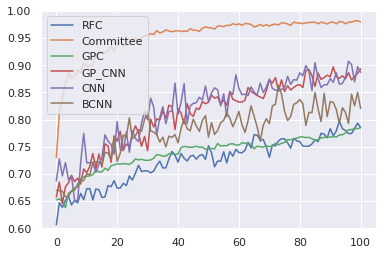

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.plot(RFC_perf_hist, label="RFC")
plt.plot(EnsemDropout_perf_hist, label="Committee")
plt.plot(GPC_perf_hist, label="GPC")
plt.plot(GP_CNN_perf_hist, label="GP_CNN")
plt.plot(CNN_perf_hist, label="MC_CNN")
plt.plot(BCNN_perf_hist, label="BCNN")
plt.ylim([0.6,1])
plt.legend()

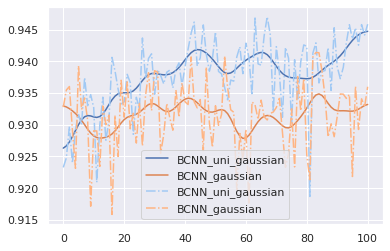

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

colors=sns.color_palette('pastel')
colors

sns.set()
plt.plot(bcnn_gaussian_mean, label="BCNN_gaussian")
plt.plot(bcnn_uni_gaussian_mean, label="BCNN_uni_gaussian")

plt.plot(bcnn_mean, '-.', label="BCNN", color=colors[0])
plt.plot(bcnn_uni_mean, '-.', label="BCNN_uni", color=colors[1])
# plt.ylim([0.6,1])
plt.legend()

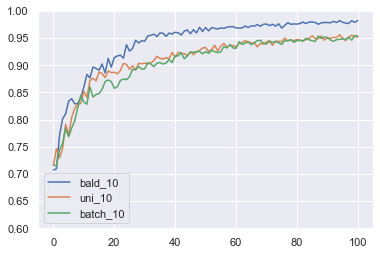

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

CNN_perf_hist = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_baldMC_perf_hist_inst10.npy')
CNN_uni_perf_hist = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_uni_perf_hist_inst10.npy')
# CNN_new_perf_hist = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_new_perf_hist_inst10.npy')
CNN_batch_perf_hist = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_batch_perf_hist_inst10_viascore.npy')
# CNN_batch_perf_hist3 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/CNN_batch_perf_hist_inst3.npy')

sns.set()
plt.plot(CNN_perf_hist, label="bald_10")
plt.plot(CNN_uni_perf_hist, label="uni_10")
plt.plot(CNN_batch_perf_hist, label="batch_10")

plt.ylim([0.6, 1])
plt.legend()

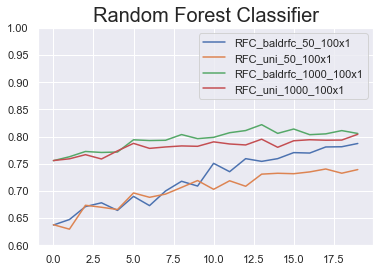

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

BCNN_baldMC_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_baldMC_50_100x1.npy')
BCNN_baldMC_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_baldMC_1000_100x1.npy')
BCNN_uni_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_uni_50_100x1.npy')
BCNN_uni_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/BCNN_uni_1000_100x1.npy')
GP_CNN_baldMC_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_baldMC_50_100x1.npy')
GP_CNN_baldMC_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_baldMC_1000_100x1.npy')
GP_CNN_uni_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_uni_50_100x1.npy')
GP_CNN_uni_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GP_CNN_uni_1000_100x1.npy')

GPC_baldgpc_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_baldgpc_50_100x1.npy')
GPC_baldgpc_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_baldgpc_1000_100x1.npy')
GPC_uni_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_uni_50_100x1.npy')
GPC_uni_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/GPC_uni_1000_100x1.npy')

RFC_baldrfc_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_baldrfc_50_100x1.npy')
RFC_baldrfc_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_baldrfc_1000_100x1.npy')
RFC_uni_50_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_uni_50_100x1.npy')
RFC_uni_1000_100x1 = np.load('D:/Studium/WiSe2021/SA/Project/run_adlr/RFC_uni_1000_100x1.npy')
fig = plt.gcf()
sns.set()
# plt.plot(BCNN_baldMC_50_100x1, label="BCNN_baldMC_50_100x1") 
# plt.plot(BCNN_uni_50_100x1, label="BCNN_uni_50_100x1") 
# plt.plot(BCNN_baldMC_1000_100x1, label="BCNN_baldMC_1000_100x1") 
# plt.plot(BCNN_uni_1000_100x1, label="BCNN_uni_1000_100x1") 

# plt.plot(GP_CNN_baldMC_50_100x1, label="GP_CNN_baldMC_50_100x1") 
# plt.plot(GP_CNN_uni_50_100x1, label="GP_CNN_uni_50_100x1") 
# plt.plot(GP_CNN_baldMC_1000_100x1, label="GP_CNN_baldMC_1000_100x1") 
# plt.plot(GP_CNN_uni_1000_100x1, label="GP_CNN_uni_1000_100x1") 

# plt.plot(GPC_baldgpc_50_100x1, label="GPC_baldgpc_50_100x1") 
# plt.plot(GPC_uni_50_100x1, label="GPC_uni_50_100x1") 
# plt.plot(GPC_baldgpc_1000_100x1, label="GPC_baldgpc_1000_100x1") 
# plt.plot(GPC_uni_1000_100x1, label="GPC_uni_1000_100x1") 

plt.plot(RFC_baldrfc_50_100x1[1:102:5], label="RFC_baldrfc_50_100x1") 
plt.plot(RFC_uni_50_100x1[1:102:5], label="RFC_uni_50_100x1") 
plt.plot(RFC_baldrfc_1000_100x1[1:102:5], label="RFC_baldrfc_1000_100x1") 
plt.plot(RFC_uni_1000_100x1[1:102:5], label="RFC_uni_1000_100x1") 


# fig.set_size_inches(18.5, 10.5)
plt.ylim([0.6, 1])
plt.title('Random Forest Classifier', fontsize=20)

plt.legend()